In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os
dir='Plots'
if not os.path.exists(dir):
    os.makedirs(dir)

# Run -defaults write org.python.python ApplePersistenceIgnoreState NO- before executing -python3 <filename>- if running from mac terminal

# Solver Class

In [212]:
class solver():

  def __init__(self,
              scheme_acronym, 
              fluid_velocity = 1,
              fluid_density = 0.5,
              Gamma = 0.5,
              domain_L = 1,
              inlet_bc = 100,
              outlet_bc = 20,
              gridpoints = 10
              ):
    
    # Global Attributes
    self.scheme = scheme_acronym
    
    self.u = fluid_velocity
    self.rho = fluid_density
    self.Gamma = Gamma
    self.L = domain_L
    self.dx = self.L/gridpoints
    self.global_Pe = self.rho * self.u * self.L / self.Gamma
    self.local_Pe = self.rho * self.u * self.dx / self.Gamma
    
    self.x = np.array([i*self.dx for i in range(int(self.L/self.dx))])
    self.phi_0 = inlet_bc
    self.phi_L = outlet_bc
    
    self.analytical_phi = np.zeros(10*len(self.x))
    self.phi = np.zeros(int(self.L/self.dx))
    self.P = np.zeros(int(self.L/self.dx))
    self.Q = np.zeros(int(self.L/self.dx))
    self.error = 0

    #Solve for phi
    if self.scheme == "CDS": self.CDS()
    elif self.scheme == "UDS": self.UDS()
    elif self.scheme == "PLDS": self.PLDS()
    self.analytical_soln()
    self.numerical_error()

  # Getter methods
  def get_local_Pe(self): return self.local_Pe
  def get_x(self): return self.x
  def get_P(self): return self.P
  def get_Q(self): return self.Q
  def get_numerical_phi(self): return self.phi
  def get_analytical_phi(self): return self.analytical_phi
  def get_rho(self): return self.rho
  def get_u(self): return self.u
  def get_Gamma(self): return self.Gamma
  def get_gridpoint_n(self): return int(self.L/self.dx)
  def get_error(self): return self.error


  # Discretization Schemes
  def CDS(self):
    D = self.Gamma / self.dx
    F = self.rho * self.u
    #Coefficients
    a = 2*D
    b = D - 0.5 * F
    c = D + 0.5 * F

    self.TDMA(a,b,c,0)
  
  def UDS(self):
    D = self.Gamma / self.dx
    F = self.rho * self.u
    #Coefficients
    a = 2*D + max(F,0) + max(-F,0)
    b = D + max(-F,0)
    c = D + max(F,0)
  
    self.TDMA(a,b,c,0)

  def PLDS(self):
    D = self.Gamma / self.dx
    F = self.rho * self.u
    #Coefficients
    b = D*max((1-0.1*self.local_Pe)**5,0) + max(-F,0)
    c = D*max((1-0.1*self.local_Pe)**5,0) + max(F,0)
    a = b + c
  
    self.TDMA(a,b,c,0)




  ## Use Linear Algebraic Equation Solution Algorithm TDMA
  def TDMA(self,a,b,c,d):
    # Set BCs
    self.P[0], self.P[-1] = 0,0
    self.Q[0], self.Q[-1] = self.phi_0, self.phi_L

    # Forward Pass to calculate P and Q
    for i in [x+1 for x in range(len(self.x)-2)]:
      self.P[i] = b / (a - c*self.P[i-1])
      self.Q[i] = c*self.Q[i-1] / (a - c*self.P[i-1])

    # Backward Pass to calculate phi
    self.phi[-1] = self.Q[-1]
    for i in [y for y in range(len(self.x)-1)][::-1]:
      self.phi[i] = self.P[i] * self.phi[i+1] + self.Q[i]
  

  

  def analytical_soln(self):
    x_domain = np.array([x/10/len(self.x) for x in range(10*len(self.x))])
    self.analytical_phi = self.phi_0 + (np.exp(self.global_Pe * x_domain/self.L)-1)/(np.exp(self.global_Pe)-1) * (self.phi_L-self.phi_0)

  def numerical_error(self):
    for i in range(len(self.phi)):
      self.error += 100*self.dx/self.L * (self.phi[i]-self.analytical_phi[10*i])/self.analytical_phi[10*i]
    

  

In [216]:
def comp_phi_plot(scheme, velocity):

  solve = solver(scheme, velocity)
  print(f"""Domain properties are set to: 
        Gamma_phi = {solve.get_Gamma()}
        Fluid Velocity = {solve.get_u()} m/s
        Fluid Density = {solve.get_rho()} kg/m^3
        Number of Gridpoints = {solve.get_gridpoint_n()}""")
  print('Solving equation in the Domain ...')

  # Solve for phi
  analytical_phi = solve.get_analytical_phi()
  start_time = time.time()
  numerical_phi = solve.get_numerical_phi()
  end_time = time.time()
  print(f"It took {end_time-start_time}s to solve the equation.")
  print(f'% Error = {round(solve.get_error(),2)}')
  print(f'Local Pe = {solve.get_local_Pe()}')
  print(f"Saving plot of phi distribution along the domain to {dir}/{scheme}...\n\n")

  # Plot phi
  fig = plt.figure()
  plt.plot([x/10/len(solve.x) for x in range(10*len(solve.x))],analytical_phi,label='Analytical Solution')
  plt.plot(solve.get_x(),numerical_phi,label=f'Numerical Solution ({scheme})')

  plt.title(r'Distribution of $\phi$ along the domain')
  plt.xlabel('x')
  plt.ylabel(r'$\phi$')
  plt.legend()
  # plt.show()
  plt.savefig(f'{dir}/{scheme}',dpi=800)


# Main

What fluid velocity would you like to test? Please enter a float or an integer.
What fluid velocity would you like to test? Please enter a float or an integer.
<class 'int'>
The constant fluid velocity in the domain has been set to 10 m/s
Please choose a discretization scheme. Type one of the following options into the command prompt: 
	CDS 
	UDS 
	PLDS
You have chosen to discretize the convection component of the phi convection-diffusion equation with the Central Differencing Scheme


Domain properties are set to: 
        Gamma_phi = 0.5
        Fluid Velocity = 10 m/s
        Fluid Density = 0.5 kg/m^3
        Number of Gridpoints = 10
Solving equation in the Domain ...
It took 9.5367431640625e-07s to solve the equation.
% Error = -9.67
Local Pe = 1.0
Saving plot of phi distribution along the domain to Plots/CDS...




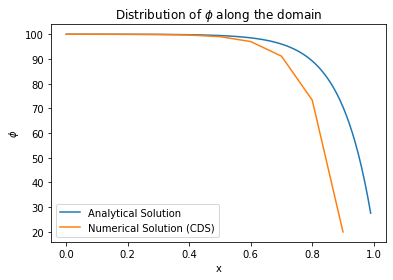

In [221]:
scheme_dict = {'CDS':'Central Differencing Scheme',
               'UDS':'Upwind Differencing Scheme',
               'PLDS':'Power Law Differencing Scheme'}

#Ask user what fluid velocity they would like to try
while True:
  print("What fluid velocity would you like to test? Please enter a float or an integer.")
  velocity = input()
  try: velocity = int(velocity)
  except ValueError:
    try: velocity = float(velocity)
    except ValueError: continue
  break
print(type(velocity))
print(f'The constant fluid velocity in the domain has been set to {velocity} m/s')

#Ask user what type of differencing scheme they would like to try
while True:
  print("Please choose a discretization scheme. Type one of the following options into the command prompt: \n\tCDS \n\tUDS \n\tPLDS")
  scheme_text = input()
  if scheme_text in ['CDS','UDS','PLDS']: break
  print("Please ensure you have entered the acronym in all caps with no spaces!")
print(f"You have chosen to discretize the convection component of the phi convection-diffusion equation with the {scheme_dict[scheme_text]}\n\n")

#Plot the numerical solution against the analytical solution
comp_phi_plot(scheme_text,velocity)


# Error Plots

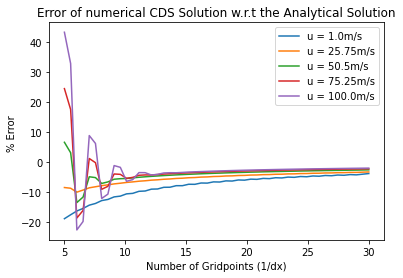

In [208]:
scheme = 'CDS'
for u in np.linspace(1,100,5):
  error_list = []
  gp_list = np.linspace(5,30)

  for gridpoints in gp_list:
    solve = solver('CDS',gridpoints=gridpoints,fluid_velocity=u)
    error_list.append(solve.get_error())


  plt.plot(gp_list,error_list,label=f'u = {u}m/s')
  plt.title(f'Error of numerical {scheme} Solution w.r.t the Analytical Solution')
  plt.ylabel('% Error ')
  plt.xlabel('Number of Gridpoints (1/dx)')

plt.legend()

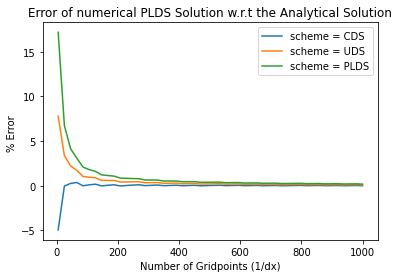

In [204]:

for scheme in ['CDS','UDS','PLDS']:
  error_list = []
  gp_list = np.linspace(5,1000)

  for gridpoints in gp_list:
    solve = solver(scheme,gridpoints=gridpoints)
    error_list.append(solve.get_error())


  plt.plot(gp_list,error_list,label=f'scheme = {scheme}')
  plt.title(f'Error of numerical {scheme} Solution w.r.t the Analytical Solution')
  plt.ylabel('% Error ')
  plt.xlabel('Number of Gridpoints (1/dx)')

plt.legend()